In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from math import sqrt

from matplotlib import pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, max_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from tensorflow import keras
%load_ext tensorboard

plt.rc("figure", figsize=(16,6))
plt.rc("font", size=13)

print("pandas version: " + pd.__version__)
print("numpy version: " + np.__version__)
print("tensorflow version: " + tf.__version__)

pandas version: 1.2.4
numpy version: 1.18.5
tensorflow version: 2.3.1


LSTM: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [618]:
df = pd.read_csv("../data/clean/trips.csv", parse_dates=["date_from", "date_until"])
df.set_index("date_until", inplace=True)
df.head(3)

,bike_id,user_id,date_from,start_station_name,start_station_id,end_station_name,end_station_id,booked_via,duration_in_min,distance_in_km,speed_in_kmh,time_since_last_checkout
date_until,,,,,,,,,,,,
2014-01-01 00:20:04,119911,341973A96CDE0DF9792F6C844622735AE4216EBF,2014-01-01 00:02:51,Enckeplatz / Hütten,131887,Königstraße / Struenseestraße,131650,Terminal HH_8 (-2624-),18,2.364129,7.880431,NaN
2014-01-01 00:10:48,118994,665D79F269FA03F84FC61F3A7F7B078D7392EC0E,2014-01-01 00:07:45,Isestraße / Hoheluftbrücke,140804,Isestraße / Hoheluftbrücke,140804,Terminal HH_63 (-2241-),4,0.000000,0.000000,NaN
2014-01-01 00:26:20,143660,B46B52FDC494E46849DB84BF84F0B99C78358E59,2014-01-01 00:09:55,Schulterblatt/Eifflerstraße,131648,Schulterblatt/Eifflerstraße,131648,Android SRH,17,0.000000,0.000000,NaN


In [619]:
weather = pd.read_csv("../data/clean/weather.csv", parse_dates=["datetime"])
weather.set_index("datetime", inplace=True)

predictors_a = weather[["temperature", "humidity"]]
predictors_b = weather[["wind_speed", "uv_index"]]

weather.head(3)

,precip_intensity,precip_probability,precip_type,temperature,humidity,wind_speed,wind_bearing,uv_index,visibility
datetime,,,,,,,,,
2014-01-01 00:00:00,0.0,0.0,none,1.93,0.81,3.91,161.0,0,9.988
2014-01-01 01:00:00,0.0,0.0,none,1.94,0.85,4.56,140.0,0,6.004
2014-01-01 02:00:00,0.0,0.0,none,1.81,0.85,4.12,143.0,0,9.988


In [620]:
weather.tail(3)

,precip_intensity,precip_probability,precip_type,temperature,humidity,wind_speed,wind_bearing,uv_index,visibility
datetime,,,,,,,,,
2017-05-16 21:00:00,0.0,0.0,none,16.14,0.86,2.01,119.0,0,10.003
2017-05-16 22:00:00,0.0,0.0,none,15.68,0.85,2.46,131.0,0,10.003
2017-05-16 23:00:00,0.0,0.0,none,15.67,0.86,1.47,144.0,0,10.003


<AxesSubplot:xlabel='datetime'>

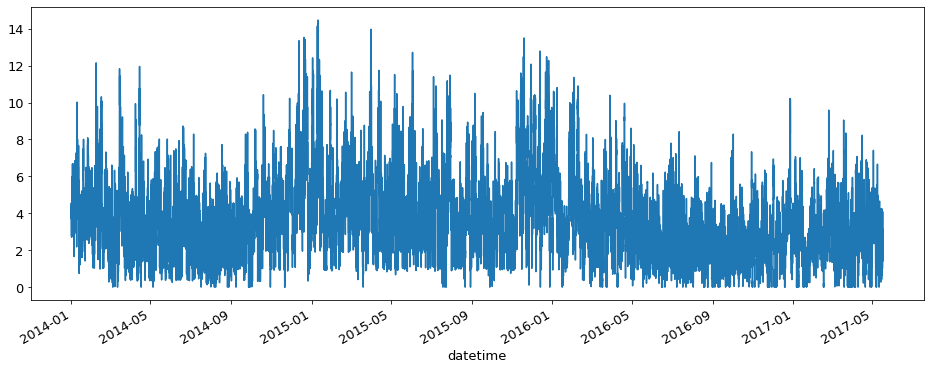

In [621]:
weather["wind_speed"].plot()

In [622]:
def print_statistics():
    df_steps = len(df_scaled)
    train_steps = len(test_x)
    test_steps = len(test_y)

    #print("Order: %s"%str(order))
    #print("Seasonal order: %s"%str(seasonal_order))
    
    print("DF steps: %s"%df_steps)
    print("Train steps: %s"%train_steps)
    print("Test steps: %s"%test_steps)

    print("MAPE: %s" %(mean_absolute_percentage_error(test_y_inv, predictions)))
    print("MSE: %s" %(mean_squared_error(test_y_inv, predictions)))
    print("RMSE: %s" %(sqrt(mean_squared_error(test_y_inv, predictions))))
    print("MedAE: %s" %(median_absolute_error(test_y_inv, predictions)))
    print("Max error: %s" %(max_error(test_y_inv, predictions)))

In [623]:
SAMPLE_START_DATE = "2015-05-01"
SAMPLE_END_DATE = "2016-4-30 23:59:59"

In [624]:
sample_df = df[["bike_id"]]
sample_df = sample_df.resample("H").count().sort_index()
sample_df = sample_df.rename(columns={"bike_id": "check_ins"})
sample_df = sample_df[pd.Timestamp(SAMPLE_START_DATE):pd.Timestamp(SAMPLE_END_DATE)]

sample_df = sample_df.merge(predictors_a, left_index=True, right_index=True)
sample_df = sample_df.merge(predictors_b, left_index=True, right_index=True)
#sample_df["hour"] = sample_df.index.hour

sample_df.head(3)

,check_ins,temperature,humidity,wind_speed,uv_index
2015-05-01 00:00:00,195,8.44,0.75,1.75,0
2015-05-01 01:00:00,209,8.00,0.77,3.76,0
2015-05-01 02:00:00,166,7.15,0.81,4.68,0


In [625]:
sample_df.tail(3)

,check_ins,temperature,humidity,wind_speed,uv_index
2016-04-30 21:00:00,285,8.36,0.79,0.70,0
2016-04-30 22:00:00,226,6.63,0.84,0.77,0
2016-04-30 23:00:00,212,5.56,0.89,1.56,0


<AxesSubplot:>

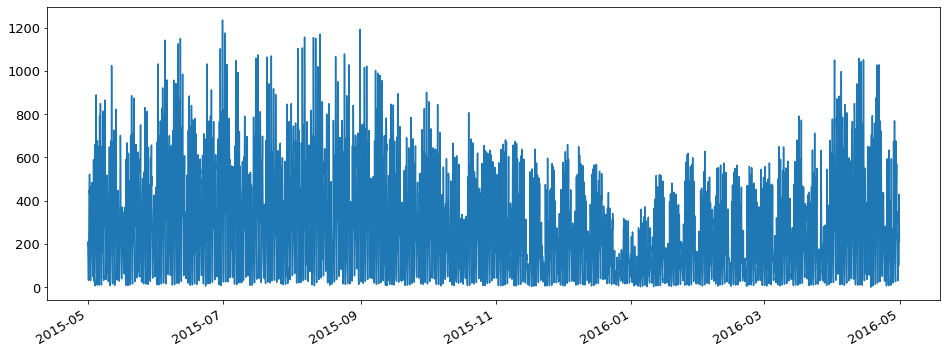

In [626]:
sample_df["check_ins"].plot()

In [627]:
FEATURE_COLUMNS = ["temperature", "humidity"]
LABEL_COLUMN = "check_ins"

def reshape_data(data): 
    features = data[FEATURE_COLUMNS]
    labels = data[[LABEL_COLUMN]]
    x = []
    y = []
    max_index = len(labels) - sequence_length
    for index in range(max_index):
        feature_sequence = features.iloc[index : (index + sequence_length)].to_numpy()
        label_value = labels.iloc[index + sequence_length]
        x.append(feature_sequence)
        y.append(label_value)
    return np.array(x), np.array(y)

In [628]:
# Normalize data

df_scaled = sample_df[FEATURE_COLUMNS].copy()

df_scaled["temperature"] = MinMaxScaler().fit_transform(sample_df[["temperature"]])
df_scaled["humidity"] = MinMaxScaler().fit_transform(sample_df[["humidity"]])
df_scaled["uv_index"] = MinMaxScaler().fit_transform(sample_df[["uv_index"]])
df_scaled["wind_speed"] = MinMaxScaler().fit_transform(sample_df[["wind_speed"]])

label_scaler = MinMaxScaler().fit(sample_df[["check_ins"]])
df_scaled["check_ins"] = label_scaler.transform(sample_df[["check_ins"]])

df_scaled.head(3)

,temperature,humidity,uv_index,wind_speed,check_ins
2015-05-01 00:00:00,0.373067,0.675325,0.0,0.129630,0.157895
2015-05-01 01:00:00,0.363209,0.701299,0.0,0.278519,0.169231
2015-05-01 02:00:00,0.344163,0.753247,0.0,0.346667,0.134413


In [629]:
sequence_length = 24
predict_next = 1

train_size = 0.8
test_size = 1.0 - train_size

In [630]:
# Split into training, testing and validation data sets
train_data, test_data = train_test_split(
    df_scaled, shuffle=False, train_size=train_size, test_size=test_size
)

In [631]:
train_x, train_y = reshape_data(train_data)
test_x, test_y = reshape_data(test_data)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(7002, 24, 2) (7002, 1)
(1733, 24, 2) (1733, 1)


In [632]:
input_shape = (train_x.shape[1], train_x.shape[2])
input_shape

(24, 2)

In [633]:
model = keras.Sequential()
lstm_1 = keras.layers.LSTM(
    units=128,
    activation="relu",
    input_shape=input_shape,
    return_sequences=True
)
lstm_2 = keras.layers.LSTM(
    units=16,
    activation="relu",
    return_sequences=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=".", histogram_freq=1)

model.add(lstm_1)
model.add(keras.layers.Dropout(0.2))
#model.add(lstm_2)
#model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_99 (LSTM)               (None, 24, 128)           67072     
_________________________________________________________________
dropout_70 (Dropout)         (None, 24, 128)           0         
_________________________________________________________________
dense_49 (Dense)             (None, 24, 1)             129       
Total params: 67,201
Trainable params: 67,201
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15
99/99 [==============================] - 3s 32ms/step - loss: 0.0360 - accuracy: 0.0000e+00 - val_loss: 0.0141 - val_accuracy: 0.0000e+00
Epoch 2/15
99/99 [==============================] - 2s 22ms/step - loss: 0.0314 - accuracy: 0.0000e+00 - val_loss: 0.0138 - val_accuracy: 0.0000e+00
Epoch 3/15
99/99 [==============================] - 2s 23ms/step - loss: 0.0307 - accuracy: 0.0000e+00 - val_loss: 0.0136 - val_accuracy: 0.0000e+00
Epoch 4/15
99/99 [==============================] - 2s 23ms/step - loss: 0.0303 - accuracy: 0.0000e+00 - val_loss: 0.0137 - val_accuracy: 0.0000e+00
Epoch 5/15
99/99 [==============================] - 3s 30ms/step - loss: 0.0299 - accuracy: 0.0000e+00 - val_loss: 0.0139 - val_accuracy: 0.0000e+00
Epoch 6/15
99/99 [==============================] - 2s 20ms/step - loss: 0.0296 - accuracy: 0.0000e+00 - val_loss: 0.0141 - val_accuracy: 0.0000e+00
Epoch 7/15
99/99 [==============================] - 2s 24ms/step - loss: 0.0293 - accuracy: 0.0000e+00 - v

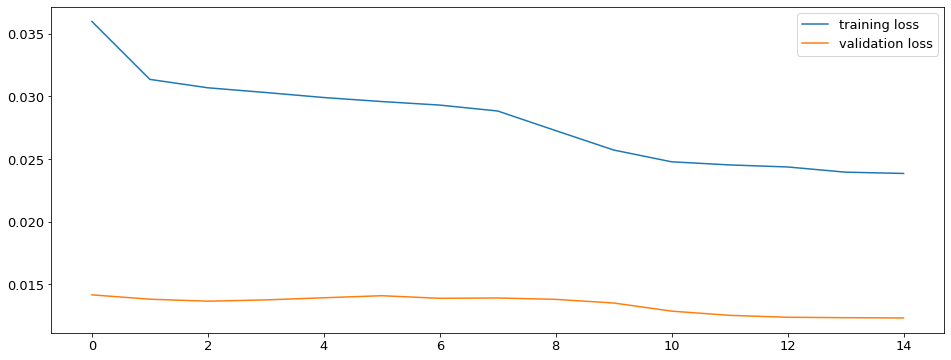

In [634]:
history = model.fit(
    train_x,
    train_y,
    validation_split=0.1,
    epochs=15,
    batch_size=64,
    shuffle=False,
    callbacks=[tensorboard_callback]
    #verbose=1
)

plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

DF steps: 8783
Train steps: 1733
Test steps: 1733
MAPE: 561907939336104.3
MSE: 36711.05438592731
RMSE: 191.60129014682366
MedAE: 121.89860534667969
Max error: 788.5835571289062


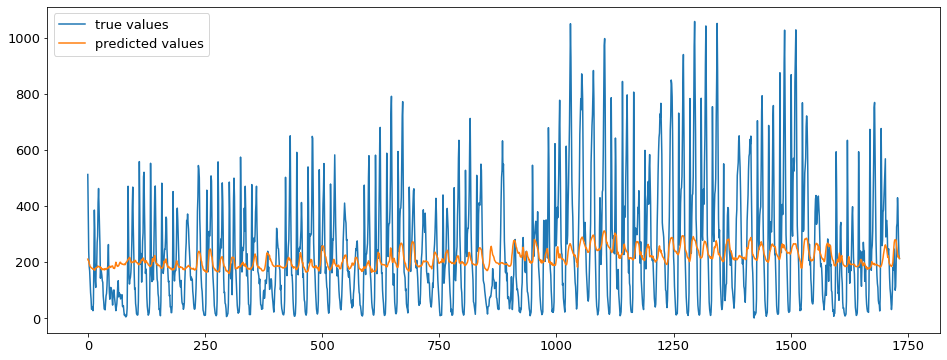

In [635]:
scaled_predictions = model.predict(test_x)

test_y_inv = label_scaler.inverse_transform(test_y)
predictions = label_scaler.inverse_transform(scaled_predictions[:,0])

print_statistics()

plt.plot(test_y_inv, label="true values")
plt.plot(predictions, label="predicted values")
plt.legend()
plt.show()

In [636]:
%tensorboard --logdir "."

Reusing TensorBoard on port 6006 (pid 41883), started 0:03:08 ago. (Use '!kill 41883' to kill it.)